## CNN application using a Kaggle Tutorial.
### I found a decent CNN tutorial which outlined the steps better than I though the classs module did and used it to see if some of things I did in the first kaggle cancer test could be aplied here as well to produce a decent final submission

### This Kaggle project is a Digit Recognizer - https://www.kaggle.com/competitions/digit-recognizer
### CNN Tutorial -- https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial/notebook

### I make references to another Kaggle project used for this class and my project I did for that here is <br> that link https://www.kaggle.com/code/keithrek/cnn-cancer-detection

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import csv
import pathlib

import itertools
import keras
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation

from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop

from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds

from PIL import Image
print(tf.__version__)
print(tfio.__version__)

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

2.12.0
0.31.0


### Set paths for different data sets



In [2]:
#print(pathlib.Path().absolute())
#print (os.getcwd())
path1 = os.getcwd()

submission_file_path = path1 + '\\Data\\sample_submission.csv'
train_path = path1 + '\\Data\\train\\'
test_path = path1 + '\\Data\\test\\'



## EDA - Data analysis review train and test data

In [3]:
# read train 
train_filename = "train.csv"
test_filename = "test.csv"

print("Train Data")
print()
train_filepath = train_path + train_filename
train_data = pd.read_csv(train_filepath)
print(train_data.shape)
print(train_data.head())

print()
print()
print("Test Data")
print()
test_filepath = test_path + test_filename
test_data = pd.read_csv(test_filepath)
print(test_data.shape)
print(test_data.head())


Train Data

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0    

## Review Training Data, the labels seem pretty evenly distributed with a few standouts at over 10% each of the data that consists of the Y train set

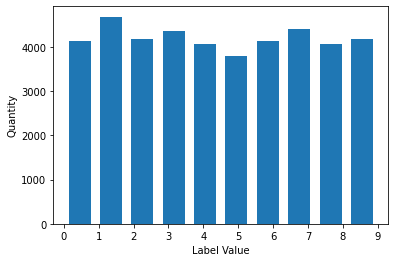


Label counts:
 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

percent of total:
 1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: label, dtype: float64

label_total:  42000


In [4]:
x1 = train_data["label"]

plt.hist(x1, rwidth=0.7)
  
plt.ylabel("Quantity")
plt.xlabel("Label Value")
plt.xticks(np.arange(min(x1), max(x1)+1, 1.0))
#plt.xticks(train_data["label"])
plt.show()

Total1 = sum(train_data["label"].value_counts())
Percent_total = (train_data["label"].value_counts()/Total1)*100
print()
print("Label counts:\n", train_data["label"].value_counts())
print()
print("percent of total:\n",Percent_total.round(2))    
print()
print("label_total: " , sum(train_data["label"].value_counts()))

In [5]:
# put labels into y_train variable
Y_train_data = train_data["label"]
# Drop 'label' column
X_train_data = train_data.drop(labels = ["label"],axis = 1) 

### Get a good view of what each data item looks like. The .values function returns a matrix like the previously used function of as_matrix id for a series data type

In [6]:
print(type(X_train_data.iloc[0]))
print(X_train_data.iloc[0])
test = X_train_data.iloc[0]
print(test.values)

<class 'pandas.core.series.Series'>
pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 0, Length: 784, dtype: int64
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 188 255  94   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 191 250 253
  93   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 123 248 253 167  10 

## Show actual Image

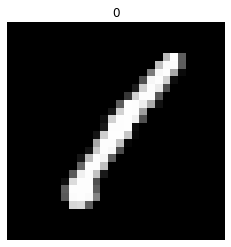

In [7]:
img = X_train_data.iloc[0].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(X_train_data.iloc[0,0])
plt.axis("off")
plt.show()

## Maintenance steps to allow for better CNN

In [8]:
# Normalize the data
X_train_data = X_train_data / 255.0
test_data = test_data / 255.0
print("x_train shape: ",X_train_data.shape)
print("test shape: ",test_data.shape)

# Reshape
X_train_data = X_train_data.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train_data.shape)
print("test shape: ",test_data.shape)

# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train_data = to_categorical(Y_train_data, num_classes = 10)


x_train shape:  (42000, 784)
test shape:  (28000, 784)
x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


## Train and validation set splits

In [54]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train1, X_val1, Y_train1, Y_val1 = train_test_split(X_train_data, Y_train_data, test_size = 0.2, random_state=2)
print("x_train shape",X_train1.shape)
print("x_test shape",X_val1.shape)
print("y_train shape",Y_train1.shape)
print("y_test shape",Y_val1.shape)

x_train shape (33600, 28, 28, 1)
x_test shape (8400, 28, 28, 1)
y_train shape (33600, 10)
y_test shape (8400, 10)


## Setting up the model

### I am new to trying to design a neural network with CNN and using this as a second project to get better acquainted with how it functions and if what I applied before witll still work well on this Kaggle Set.

### Below the Tutorial model and my modified model from the cancer kaggle CNN project are shown for comparison



#### original model from tutorial

In [55]:
model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 8)         208       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 16)         

## My Model slightly modified from the version used in the cancer image test to work with this project

In [56]:
CNN_Model1 = Sequential()

fig_size = 28
activation_value1 = 'relu'
activation_value2 = 'sigmoid'
activation_value3 = 'softmax'

CNN_Model1.add(Conv2D(filters = 8, kernel_size=(5,5),padding = 'Same', activation=activation_value1, input_shape = (28,28,1)))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))

CNN_Model1.add(Conv2D(filters=16, kernel_size=(3,3),padding = 'Same', activation=activation_value1))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))


CNN_Model1.add(Flatten())
CNN_Model1.add(Dense(units=10, activation=activation_value3))

#batch_size = 250
#CNN_Model1.build(input_shape=(batch_size, fig_size, fig_size, 3))
CNN_Model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 8)         208       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 10)               

## Compile the model

In [57]:
#Optimizer1 = SGD(name= "SGD", learning_rate = 0.0001, nesterov = False, momentum = 0.0)
Optimizer1 = Adam(learning_rate=0.001)
#optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#model.compile(optimizer=Optimizer1, loss =  "categorical_crossentropy", metrics = ['accuracy'])
CNN_Model1.compile(optimizer=Optimizer1, loss =  "categorical_crossentropy", metrics = ['accuracy'])
#CNN_Model1.compile(optimizer=Optimizer1, loss='binary_crossentropy', metrics=['accuracy'])

## Image generator for this set is designed make various changes for which some are subtle and others are not. Change examples are are axis rotating , scale changes and uncentering the image to vary it from the original input image

In [58]:


Image_Gen1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



## Running and Building the model history dataset


In [59]:
epoch_count = 40  # for better result increase the epochs
batch_size = 128

Image_Gen1.fit(X_train1)
Steps_for_Epochs = X_train1.shape[0]
# Fit the model
#CNN_Fina11 = model.fit(Image_Gen1.flow(X_train1,Y_train1, batch_size=batch_size),
#                              epochs = epoch_count, validation_data = (X_val1,Y_val1), steps_per_epoch=Steps_for_Epochs // batch_size)
CNN_Final2 = CNN_Model1.fit(Image_Gen1.flow(X_train1,Y_train1, batch_size=batch_size), shuffle = True,
                              epochs = epoch_count, validation_data = (X_val1,Y_val1), steps_per_epoch=Steps_for_Epochs // batch_size)


Epoch 1/40
262/262 [==============================] - 5s 18ms/step - loss: 0.9051 - accuracy: 0.7180 - val_loss: 0.2002 - val_accuracy: 0.9461
Epoch 2/40
262/262 [==============================] - 5s 17ms/step - loss: 0.2960 - accuracy: 0.9135 - val_loss: 0.1339 - val_accuracy: 0.9608
Epoch 3/40
262/262 [==============================] - 5s 18ms/step - loss: 0.2274 - accuracy: 0.9336 - val_loss: 0.1244 - val_accuracy: 0.9643
Epoch 4/40
262/262 [==============================] - 5s 18ms/step - loss: 0.1945 - accuracy: 0.9436 - val_loss: 0.1019 - val_accuracy: 0.9694
Epoch 5/40
262/262 [==============================] - 5s 17ms/step - loss: 0.1748 - accuracy: 0.9497 - val_loss: 0.0997 - val_accuracy: 0.9700
Epoch 6/40
262/262 [==============================] - 5s 17ms/step - loss: 0.1602 - accuracy: 0.9538 - val_loss: 0.0928 - val_accuracy: 0.9720
Epoch 7/40
262/262 [==============================] - 5s 17ms/step - loss: 0.1524 - accuracy: 0.9561 - val_loss: 0.0854 - val_accuracy: 0.9736

## Check for overfitting on Loss and Accuracy and changing positions on the charts <br> for Train vs validate

### Plot Train and Validation Loss Results

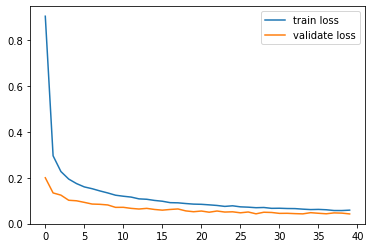

<Figure size 432x288 with 0 Axes>

In [60]:
plt.plot(CNN_Final2.history['loss'], label='train loss')
plt.plot(CNN_Final2.history['val_loss'], label='validate loss')
plt.legend()
plt.show()
plt.savefig('Loss_Comparison')

### Plot Train and Validation Accuracy Results

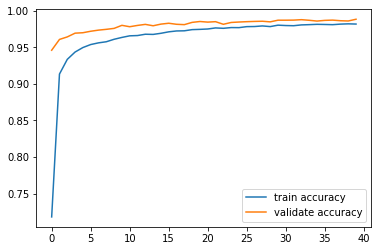

<Figure size 432x288 with 0 Axes>

In [61]:
plt.plot(CNN_Final2.history['accuracy'], label='train accuracy')
plt.plot(CNN_Final2.history['val_accuracy'], label='validate accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy_Comparison')

## Predict values and output to confusion matrix

263/263 [==============================] - 0s 2ms/step


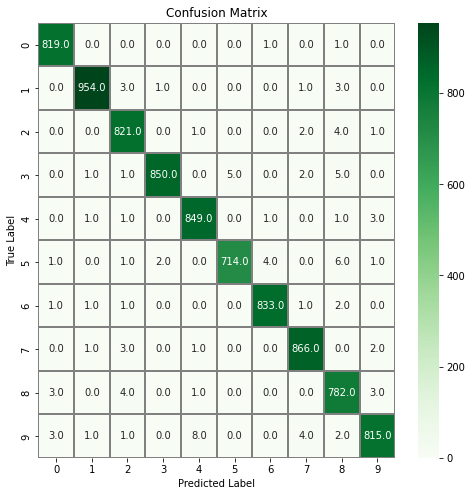

In [62]:

# Predict the values from the validation dataset
Y_pred = CNN_Model1.predict(X_val1)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val1,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Export Prediction results to file for Kaggle Submission



In [63]:
Y_pred = CNN_Model1.predict(test_data)

875/875 [==============================] - 2s 2ms/step


In [66]:
print(Y_pred)
print(np.argmax(Y_pred, axis=1))
Submission_labels = np.argmax(Y_pred, axis=1)
print(len(Y_pred))

[[2.7134699e-11 2.0839289e-11 1.0000000e+00 ... 4.3469233e-09
  2.5670011e-10 3.2434210e-14]
 [9.9998748e-01 1.0443014e-17 7.7390105e-06 ... 2.9593243e-09
  1.8015768e-07 1.4635373e-06]
 [4.6916787e-10 1.7886631e-08 3.4321849e-06 ... 1.7044031e-05
  2.2582785e-04 9.9955004e-01]
 ...
 [1.3721625e-13 6.0747615e-13 4.3009628e-08 ... 1.9051647e-09
  1.6653409e-07 1.3026822e-07]
 [4.1213268e-09 1.4946008e-06 2.4253911e-06 ... 3.9417052e-04
  5.4272402e-08 9.9616218e-01]
 [4.1174195e-12 3.5035980e-16 9.9999917e-01 ... 4.5072578e-11
  8.5529138e-07 2.2850875e-10]]
[2 0 9 ... 3 9 2]
28000


In [67]:
# Save the predictions to a CSV file
Submission_labels = np.argmax(Y_pred, axis=1)
Digitizer_Submission = pd.DataFrame({'ImageId': range(1, len(Submission_labels)+1),
                           'Label': Submission_labels})
Digitizer_Submission.to_csv('.digitizer_predictions_Softmax_Epoch_40_Split_20.csv', index=False)

# Conclusions from Tests:

## How this project differed from the Cancer project

### 1) carrying over model from Kaggle cancer worked well, but still needed minor adjustments to work with this project. The major difference between the 2 being one that the Kaggle one was a Binary and this being Categorical.

### 2) Image generators are quite a bit different. I would say that the one used a simpler method to vary the resulting image and might help with being able to predict the test images a little easier. 

### 3) Setting and varying the validation split matters in both cases, but for the this project raising it did not improve the submission score. The original tutorial was using 0.10. Typically I would increase this to around 0.30 to get larger set of validation data for confirming results on the train set, but this resulted in slightly worse performance a my score dropped from 0.98707 to 0.98271. I know there is typically a break point with respect to how high your should go with that data split but in this case more was definitely not better.

### 4 ) Activation functions on the Final Layer: I tried relu, sigmoid, softmax for this project and much like the tutorial the softmax performs the best. I compared over different epoch counts, validation splits and batch sizes. with the Softmax perfoming best followed by sigmoid 

### 5) Batch Sizes: This parameter was varied from an original setting of 512 to 1024, 256, 128. I found 128 to be really consistent when running tests an eventually stuck with it for remainder of my submissions. Getting this right can make a big difference in your results and for graphing output.

### 6) Epoch Counts: On the cancer kaggle project the Epoch count was quite low (3-5) before overfitting. This project that epoch count was much higher. The graphing showing how well it fitted. This one would probably benefit from an addition of an early stopping implementation to help achieve a bette score rather than manually inputing a new value each time you wanted to test a change to the model



# Overall this second run at a CNN model definitely help with my understanding and ability implement these machine learning methods in Python, but still would need more training and practice to get these right on a consistent basis.